## Impact of Trump's Tweets Based on Favorite and Retweet Counts

In this notebook I look at the number of favorite and retweet counts received by Trump's and Clinton's tweets, and their evolution since Dec 2015 (the earliest tweet I was able to retrieve using the Twitter API).

In [17]:
import datetime

import numpy as np
import pandas as pd
import nltk

%matplotlib inline
from matplotlib import pyplot as plt
from bokeh.charts import TimeSeries, Step
from bokeh.io import output_notebook
from bokeh.plotting import figure, ColumnDataSource, output_file, show
from bokeh.models import HoverTool

from utils import is_article_quote, is_copy_paste

pd.set_option('max_colwidth',150)

Read the tweet info from the csv file.

In [18]:
root_dir = "/Users/gogrean/Documents/kaggle/off_kaggle_ds/elect2016/"
df_trump = pd.read_csv(root_dir + "data/trumps_tweets.csv")
df_clinton = pd.read_csv(root_dir + "data/clintons_tweets.csv")

Some of Trump's retweets are done by copy-pasting other users' tweets. Both Trump and Clinton also occasionally quote content from articles. Because these tweets are not original candidate statements, they are removed from the analysis.

In [19]:
for i, text in enumerate(df_trump.text):
    df_trump.at[i, 'copy_paste'] = is_copy_paste(text)
    df_trump.at[i, 'article_quote'] = is_article_quote(text)

df_trump = df_trump.loc[(df_trump.copy_paste == False) & 
                        (df_trump.article_quote == False) & 
                        (df_trump.is_retweet == False), :]

for i, text in enumerate(df_clinton.text):
    df_clinton.at[i, 'copy_paste'] = is_copy_paste(text)
    df_clinton.at[i, 'article_quote'] = is_article_quote(text)

df_clinton = df_clinton.loc[(df_clinton.copy_paste == False) & 
                            (df_clinton.article_quote == False) & 
                            (df_clinton.is_retweet == False), :]

The date of the tweets is saved in the `created_at` field. This field saves the date as, e.g.

`Sat Dec 12 19:21:15 +0000 2015`

so this needs to be pre-processed to extract the date.

In [20]:
df_trump['date'] = [data[-4:] + data[3:10] for data in df_trump['created_at']]
df_trump['date'] = pd.to_datetime(df_trump.date)

df_clinton['date'] = [data[-4:] + data[3:10] for data in df_clinton['created_at']]
df_clinton['date'] = pd.to_datetime(df_clinton.date)

I calculate the total impact of the tweet as the sum of favorite and retweet counts, and save this number in the `favs_plus_retweets` column of the dataframe.

In [21]:
df_trump['favs_plus_retweets'] = df_trump['favorite_count'] + df_trump['retweet_count']
df_clinton['favs_plus_retweets'] = df_clinton['favorite_count'] + df_clinton['retweet_count']

Below I plot the evolution of favorite and retweet counts with time. The tweets are grouped by date. Because the number of tweets posted each day is not the same, I normalize the total favorites, retweets, and impact (favorites + retweets) by the number of tweets posted that day. The dates and average favorites/retweets/impact are saved in lists that are used below create the dictionary that will passed to the `Bokeh` plotting functions. The figure created is interactive, and the reader can zoom in on a particular date range.

In [22]:
for candidate, df in zip(['Trump', 'Clinton'], [df_trump, df_clinton]):
    dates, average_favs, average_retweets, average_impact = [], [], [], []
    for date, group in df.groupby(df['date']):
        n_tweets = len(group['favorite_count'])
        average_favs_on_date = group.favorite_count.sum() / n_tweets / 1e3
        average_retweets_on_date = group.retweet_count.sum() / n_tweets / 1e3
        average_impact_on_date = group.favs_plus_retweets.sum() / n_tweets / 1e3
        dates.append(date)
        average_favs.append(average_favs_on_date)
        average_retweets.append(average_retweets_on_date)
        average_impact.append(average_impact_on_date)

    data = dict(
        Date = dates,
        Favorites = average_favs,
        Retweets = average_retweets,
        Impact = average_impact
    )

    output_notebook()
    FIG_TOOLS = "pan,wheel_zoom,box_zoom,reset,resize,save"

    output_file(root_dir + "figs/evolution_of_" + candidate.lower() + "_tweets_impact.html")

    p = figure(tools=FIG_TOOLS,
               width=800, height=350, x_axis_type="datetime", 
               title="Impact of " + candidate + "'s Tweets Based on Retweets and Favorites")
    p.line(data['Date'], data['Favorites'], line_color='navy', 
           alpha=0.75, line_width=2, legend='Favorites')
    p.line(data['Date'], data['Retweets'], line_color='green', 
           alpha=0.75, line_width=2, legend='Retweets')
    p.line(data['Date'], data['Impact'], line_color='orange', 
           alpha=0.75, line_width=2, legend='Impact (Favorites + Retweets)')
    p.xaxis.axis_label = 'Date'
    p.yaxis.axis_label = 'Average Tweet Impact (x 1K)'

    # styling stuff to make the plot look prettier
    for attr in [p.xaxis, p.yaxis]:
        attr.major_label_text_font = 'times'
        attr.major_label_text_font_size = '10pt'
        attr.axis_label_text_font = 'times'
        attr.axis_label_text_font_size = '12pt'
        attr.axis_label_text_font_style = 'bold'
    p.title.text_font = 'times'
    p.title.text_font_size = '14pt'
    p.title.text_font_style = 'bold'
    p.legend.location = "top_left"
    
    show(p)

Loading BokehJS ...

Loading BokehJS ...

Next I look at the tweets with the most and least favorites as a function of time. For each day, if at least one of the tweets posted that day had a favorite, I save the text of the tweet with the most/least favorites and the number of favorites. If only one tweet posted in a day received favorites, the most and least favorited tweet will be the same, because I ignore tweets with no favorite votes. 

Lists containing the dates, the text of most/least favorited tweet, and the corresponding number of favorites are used to build the dictionary that is passed to the `Bokeh` plotting routines. I then plot the favorites received by the most and least favorited tweets each day.

In [23]:
for candidate, df in zip(['Trump', 'Clinton'], [df_trump, df_clinton]):
    most_favorite_tweets, least_favorite_tweets = [], []

    for date, group in df.groupby(df['date']):
        if len(group) == 0:
            continue
        if group.favorite_count.sum() == 0:
            continue

        ix_max = group.favorite_count.argmax()
        favorite_tweet_on_day = group.text.at[ix_max]
        favorites_received = group.favorite_count.at[ix_max]
        most_favorite_tweets.append((date, favorites_received, favorite_tweet_on_day))

        ix_min = group[group.favorite_count > 0].favorite_count.argmin()
        least_favorite_tweet_on_day = group[group.favorite_count > 0].text.at[ix_min]
        least_favorites_received = group[group.favorite_count > 0].favorite_count.at[ix_min]
        least_favorite_tweets.append((date, least_favorites_received, least_favorite_tweet_on_day))

    data = dict(
        DateMostFavorites = [x[0] for x in most_favorite_tweets],
        MostFavoritesReceived = [x[1]/1e3 for x in most_favorite_tweets],
        MostFavoriteTweet = [x[2] for x in most_favorite_tweets],
        DateLeastFavorites = [x[0] for x in least_favorite_tweets],
        LeastFavoritesReceived = [x[1]/1e3 for x in least_favorite_tweets],
        LeastFavoriteTweet = [x[2] for x in least_favorite_tweets]
    )

    source = ColumnDataSource(data)
    
    output_notebook()
    FIG_TOOLS = "pan,wheel_zoom,box_zoom,reset,resize,crosshair,save"

    # Custom tooltip, because the default is too restrictive.
    TOOLTIPS = """
               <div>
                   <div>
                    <img
                        src="https://g.twimg.com/Twitter_logo_blue.png" 
                        height="20" width="20"
                        style="float: left; margin: 5px 15px 15px 0px;"
                    ></img>
                </div>
                <div style="width: 20em; word-wrap: break-word;
                            margin: 0px 0px 0px 35px">
                    <span style="font-size: 12px; font-style: italic; 
                     color: #4682B4; background-color: #FFFAFA;">@MostFavoriteTweet</span>
                </div>
            </div>
    """

    output_file(root_dir + "figs/" + candidate.lower() + "_tweets_with_most_favorites.html")

    p = figure(tools=FIG_TOOLS,
               width=800, height=350, x_axis_type="datetime", 
               title=candidate + "'s Tweets with Most Favorites",
               y_range=(0, np.max([x[1]/1e3 for x in most_favorite_tweets]) * 1.1))
    p.line(data['DateMostFavorites'], data['MostFavoritesReceived'], line_color='navy', 
           alpha=0.75, line_width=2)

    # Make renderer for the scatter plot.
    favs_scat_r = p.scatter(data['DateMostFavorites'], data['MostFavoritesReceived'], line_color='navy', 
              alpha=0.75, source=source)

    # Add hover tool.
    favs_scat_hover = HoverTool(renderers=[favs_scat_r], 
                                tooltips=TOOLTIPS)
    p.add_tools(favs_scat_hover)

    p.xaxis.axis_label = 'Date'
    p.yaxis.axis_label = 'Favorites (x 1K)'

    # styling stuff to make it look prettier
    for attr in [p.xaxis, p.yaxis]:
        attr.major_label_text_font = 'times'
        attr.major_label_text_font_size = '10pt'
        attr.axis_label_text_font = 'times'
        attr.axis_label_text_font_size = '12pt'
        attr.axis_label_text_font_style = 'bold'
    p.title.text_font = 'times'
    p.title.text_font_size = '14pt'
    p.title.text_font_style = 'bold'
    p.legend.location = "top_left"

    show(p)
    
    output_notebook()
    FIG_TOOLS = "pan,wheel_zoom,box_zoom,reset,resize,crosshair,save"

    # Custom tooltip, because the default is too restrictive.
    TOOLTIPS = """
               <div>
                   <div>
                    <img
                        src="https://g.twimg.com/Twitter_logo_blue.png" 
                        height="20" width="20"
                        style="float: left; margin: 5px 15px 15px 0px;"
                    ></img>
                </div>
                <div style="width: 20em; word-wrap: break-word;
                            margin: 0px 0px 0px 35px">
                    <span style="font-size: 12px; font-style: italic; 
                     color: #4682B4; background-color: #FFFAFA;">@LeastFavoriteTweet</span>
                </div>
            </div>
    """

    output_file(root_dir + "figs/" + candidate.lower() + "_tweets_with_least_favorites.html")

    p = figure(tools=FIG_TOOLS,
               width=800, height=350, x_axis_type="datetime", 
               title=candidate + "'s Tweets with Least Favorites",
               y_range=(0, np.max([x[1]/1e3 for x in least_favorite_tweets]) * 1.1))
    p.line(data['DateLeastFavorites'], data['LeastFavoritesReceived'], line_color='navy', 
           alpha=0.75, line_width=2)

    # Make renderer for the scatter plot.
    favs_scat_r = p.scatter(data['DateLeastFavorites'], data['LeastFavoritesReceived'], line_color='navy', 
              alpha=0.75, source=source)

    # Add hover tool.
    favs_scat_hover = HoverTool(renderers=[favs_scat_r], 
                                tooltips=TOOLTIPS)
    p.add_tools(favs_scat_hover)

    p.xaxis.axis_label = 'Date'
    p.yaxis.axis_label = 'Favorites (x 1K)'

    # styling stuff to make it look prettier
    for attr in [p.xaxis, p.yaxis]:
        attr.major_label_text_font = 'times'
        attr.major_label_text_font_size = '10pt'
        attr.axis_label_text_font = 'times'
        attr.axis_label_text_font_size = '12pt'
        attr.axis_label_text_font_style = 'bold'
    p.title.text_font = 'times'
    p.title.text_font_size = '14pt'
    p.title.text_font_style = 'bold'

    show(p)

Loading BokehJS ...

Loading BokehJS ...

Loading BokehJS ...

Loading BokehJS ...

I print some statistics about the tweets based on the number of favorites.

In [8]:
for candidate, df in zip(['Trump', 'Clinton'], [df_trump, df_clinton]):
    # Median favorites received.
    print("Median number of favorites received by " + candidate + "'s tweets: %i. \n" 
          % df.favorite_count.median())

    # Finds tweet with the least favorites.
    min_favorite_votes = df.favorite_count.min()
    min_favorite_arg = df.favorite_count.argmin()
    min_favorite_tweet = df.at[min_favorite_arg, 'text']
    print(candidate + "'s tweet with least favorites is '%s' and has %i favorite votes. \n" 
          % (min_favorite_tweet, min_favorite_votes))

    # Finds tweet with the most favorites.
    max_favorite_votes = df.favorite_count.max()
    max_favorite_arg = df.favorite_count.argmax()
    max_favorite_tweet = df.at[max_favorite_arg, 'text']
    print(candidate + "'s tweet with most favorites is '%s' and has %i favorite votes. \n" 
          % (max_favorite_tweet, max_favorite_votes))

Median number of favorites received by Trump's tweets: 13494. 

Trump's tweet with least favorites is 'Chris Wallace @fox at 10:00 A.M.' and has 1589 favorite votes. 

Trump's tweet with most favorites is 'How long did it take your staff of 823 people to think that up--and where are your 33,000 emails that you deleted? https://t.co/gECLNtQizQ' and has 291706 favorite votes. 

Median number of favorites received by Clinton's tweets: 3808. 

Clinton's tweet with least favorites is '@MaryKayHenry Nobody knows better than unions that we’re stronger together. Honored to join you all in the fight for working families.' and has 274 favorite votes. 

Clinton's tweet with most favorites is 'Delete your account. https://t.co/Oa92sncRQY' and has 646879 favorite votes. 



I also looked at the tweets with the most and least retweets as a function of time.

In [9]:
for candidate, df in zip(['Trump', 'Clinton'], [df_trump, df_clinton]):
    most_retweeted_tweets, least_retweeted_tweets = [], []

    for date, group in df.groupby(df['date']):
        if len(group) == 0:
            continue
        if group.retweet_count.sum() == 0:
            continue

        ix_max = group.retweet_count.argmax()
        most_retweeted_tweet_on_day = group.text.at[ix_max]
        retweets_received = group.retweet_count.at[ix_max]
        most_retweeted_tweets.append((date, retweets_received, most_retweeted_tweet_on_day))

        ix_min = group[group.retweet_count > 0].retweet_count.argmin()
        least_retweeted_tweet_on_day = group[group.retweet_count > 0].text.at[ix_min]
        least_retweets_received = group[group.retweet_count > 0].retweet_count.at[ix_min]
        least_retweeted_tweets.append((date, least_retweets_received, least_retweeted_tweet_on_day))

    data = dict(
        DateMostRetweets = [x[0] for x in most_retweeted_tweets],
        MostRetweetsReceived = [x[1]/1e3 for x in most_retweeted_tweets],
        MostRetweetedTweet = [x[2] for x in most_retweeted_tweets],
        DateLeastRetweets = [x[0] for x in least_retweeted_tweets],
        LeastRetweetsReceived = [x[1]/1e3 for x in least_retweeted_tweets],
        LeastRetweetedTweet = [x[2] for x in least_retweeted_tweets]
    )

    source = ColumnDataSource(data)

    output_notebook()
    FIG_TOOLS = "pan,wheel_zoom,box_zoom,reset,resize,crosshair,save"

    # Custom tooltip, because the default is too restrictive.
    TOOLTIPS = """
               <div>
                   <div>
                    <img
                        src="https://g.twimg.com/Twitter_logo_blue.png" 
                        height="20" width="20"
                        style="float: left; margin: 5px 15px 15px 0px;"
                    ></img>
                </div>
                <div style="width: 20em; word-wrap: break-word;
                            margin: 0px 0px 0px 35px">
                    <span style="font-size: 12px; font-style: italic; 
                     color: #4682B4; background-color: #FFFAFA;">@MostRetweetedTweet</span>
                </div>
            </div>
    """

    output_file(root_dir + "figs/" + candidate.lower() + "_tweets_with_most_retweets.html")

    p = figure(tools=FIG_TOOLS,
               width=800, height=350, x_axis_type="datetime", 
               title=candidate + "'s Tweets with Most Retweets",
               )
    p.line(data['DateMostRetweets'], data['MostRetweetsReceived'], line_color='navy', 
           alpha=0.75, line_width=2)

    # Make renderer for the scatter plot.
    retweets_scat_r = p.scatter(data['DateMostRetweets'], data['MostRetweetsReceived'], line_color='navy', 
                                alpha=0.75, source=source)

    # Add hover tool.
    retweets_scat_hover = HoverTool(renderers=[retweets_scat_r], 
                                    tooltips=TOOLTIPS)
    p.add_tools(retweets_scat_hover)

    p.xaxis.axis_label = 'Date'
    p.yaxis.axis_label = 'Retweets (x 1K)'

    # styling stuff to make it look prettier
    for attr in [p.xaxis, p.yaxis]:
        attr.major_label_text_font = 'times'
        attr.major_label_text_font_size = '10pt'
        attr.axis_label_text_font = 'times'
        attr.axis_label_text_font_size = '12pt'
        attr.axis_label_text_font_style = 'bold'
    p.title.text_font = 'times'
    p.title.text_font_size = '14pt'
    p.title.text_font_style = 'bold'
    p.legend.location = "top_left"

    show(p)

    output_notebook()
    FIG_TOOLS = "pan,wheel_zoom,box_zoom,reset,resize,crosshair,save"

    # Custom tooltip, because the default is too restrictive.
    TOOLTIPS = """
               <div>
                   <div>
                    <img
                        src="https://g.twimg.com/Twitter_logo_blue.png" 
                        height="20" width="20"
                        style="float: left; margin: 5px 15px 15px 0px;"
                    ></img>
                </div>
                <div style="width: 20em; word-wrap: break-word;
                            margin: 0px 0px 0px 35px">
                    <span style="font-size: 12px; font-style: italic; 
                     color: #4682B4; background-color: #FFFAFA;">@LeastRetweetedTweet</span>
                </div>
            </div>
    """

    output_file(root_dir + "figs/" + candidate.lower() + "_tweets_with_least_retweets.html")

    p = figure(tools=FIG_TOOLS,
               width=800, height=350, x_axis_type="datetime", 
               title=candidate + "'s Tweets with Least Retweets"
               )
    p.line(data['DateLeastRetweets'], data['LeastRetweetsReceived'], line_color='navy', 
           alpha=0.75, line_width=2)

    # Make renderer for the scatter plot.
    retweets_scat_r = p.scatter(data['DateLeastRetweets'], data['LeastRetweetsReceived'], line_color='navy', 
                                alpha=0.75, source=source)

    # Add hover tool.
    retweets_scat_hover = HoverTool(renderers=[retweets_scat_r], 
                                    tooltips=TOOLTIPS)
    p.add_tools(retweets_scat_hover)

    p.xaxis.axis_label = 'Date'
    p.yaxis.axis_label = 'Retweets (x 1K)'

    # styling stuff to make it look prettier
    p.xaxis.axis_label_text_font_size = '10pt'
    p.yaxis.axis_label_text_font_size = '10pt'
    p.title.text_font_size = '12pt'
    p.xaxis.axis_label_text_font_style = 'bold'
    p.yaxis.axis_label_text_font_style = 'bold'
    p.title.text_font_style = 'bold'
    p.legend.location = "top_left"

    show(p)

Loading BokehJS ...

Loading BokehJS ...

Loading BokehJS ...

Loading BokehJS ...

To compare the evolution of favorite and retweet counts for Trump's and Clinton's tweets, I modeled the evolution of most and least liked tweets with a linear function. The best-fitting models are plotted on top of the data, and the slope is listed in the legend. The slopes of the lines fitted to Trump's data are all higher than Clinton's, showing that the popularity of his tweets increases faster. 

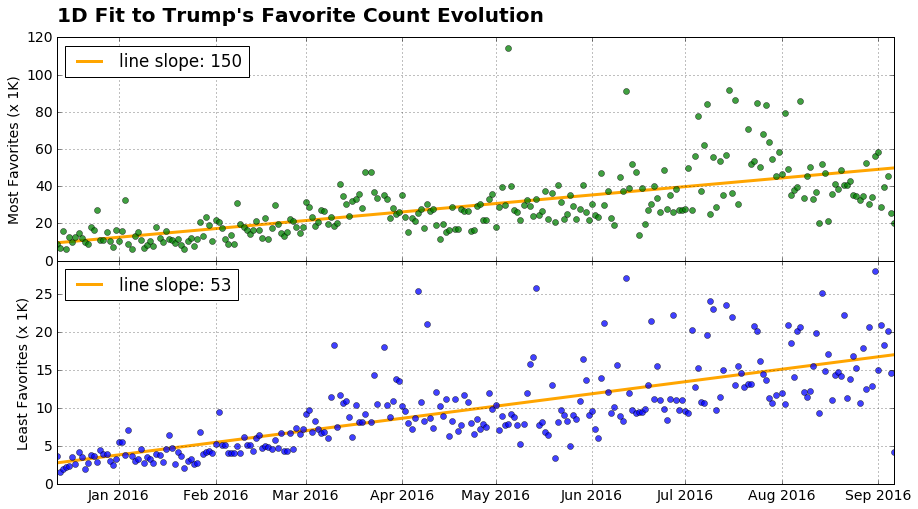

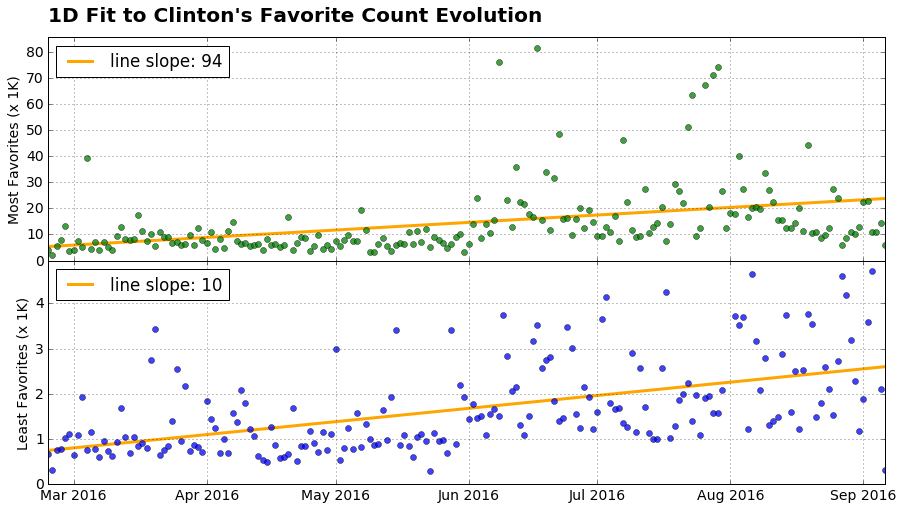

In [16]:
import matplotlib.dates as mdates
plt.rcParams.update({'font.size': 14})

for candidate, df in zip(['Trump', 'Clinton'], [df_trump, df_clinton]):
    most_favorite_tweets, least_favorite_tweets = [], []

    for date, group in df.groupby(df['date']):
        if len(group) == 0:
            continue
        if group.favorite_count.sum() == 0:
            continue

        ix_max = group.favorite_count.argmax()
        favorite_tweet_on_day = group.text.at[ix_max]
        favorites_received = group.favorite_count.at[ix_max]
        most_favorite_tweets.append((date, favorites_received, favorite_tweet_on_day))

        ix_min = group[group.favorite_count > 0].favorite_count.argmin()
        least_favorite_tweet_on_day = group[group.favorite_count > 0].text.at[ix_min]
        least_favorites_received = group[group.favorite_count > 0].favorite_count.at[ix_min]
        least_favorite_tweets.append((date, least_favorites_received, least_favorite_tweet_on_day))

    # plot most favorites trend
    mean_favs = np.mean([x[1] for x in most_favorite_tweets])
    sig_favs = np.std([x[1] for x in most_favorite_tweets])
    x = mdates.date2num([x[0] for x in most_favorite_tweets 
                         if mean_favs - 3*sig_favs < x[1] < mean_favs + 3*sig_favs])
    y = np.array([x[1] for x in most_favorite_tweets 
                  if mean_favs - 3*sig_favs < x[1] < mean_favs + 3*sig_favs])

    coef = np.polyfit(x, y, 1)
    poly = np.poly1d(coef)

    fig, cx = plt.subplots(2, figsize=(15, 8), sharex=True)

    xx = np.linspace(x.min(), x.max(), 100)
    dd = mdates.num2date(xx)

    cx[0].plot(dd, poly(xx)/1e3, color='orange', 
               linestyle='solid', linewidth=3, label="line slope: %.0f" % coef[0])
    cx[0].plot(x, y/1e3, 'o', color='green', alpha=0.75)
    cx[0].set_ylabel('Most Favorites (x 1K)')
    cx[0].legend(loc='upper left')
    cx[0].set_ylim([0, np.max(y/1e3)*1.05])
    cx[0].grid()

    # plot least favorites trend
    mean_favs = np.mean([x[1] for x in least_favorite_tweets])
    sig_favs = np.std([x[1] for x in least_favorite_tweets])
    x = mdates.date2num([x[0] for x in least_favorite_tweets if mean_favs - 3*sig_favs < x[1] < mean_favs + 3*sig_favs])
    y = np.array([x[1] for x in least_favorite_tweets if mean_favs - 3*sig_favs < x[1] < mean_favs + 3*sig_favs])

    coef = np.polyfit(x, y, 1)
    poly = np.poly1d(coef)

    xx = np.linspace(x.min(), x.max(), 100)
    dd = mdates.num2date(xx)

    cx[1].plot(dd, poly(xx)/1e3, color='orange', 
               linestyle='solid', linewidth=3, label="line slope: %.0f" % coef[0])
    cx[1].plot(x, y/1e3, 'o', color='blue', alpha=0.75)
    cx[1].set_ylabel('Least Favorites (x 1K)')
    cx[1].legend(loc='upper left')
    cx[1].set_ylim([0, np.max(y/1e3) * 1.05])
    cx[1].grid()

    cx[0].set_title("1D Fit to " + candidate + "'s Favorite Count Evolution", 
                    loc='left', y=1.05, fontsize='x-large', weight='heavy')

    fig.subplots_adjust(hspace=0)
    fig.savefig(root_dir + 'figs/1Dfit_" + candidate.lower() + "_favorite_tweets_evolution.pdf')

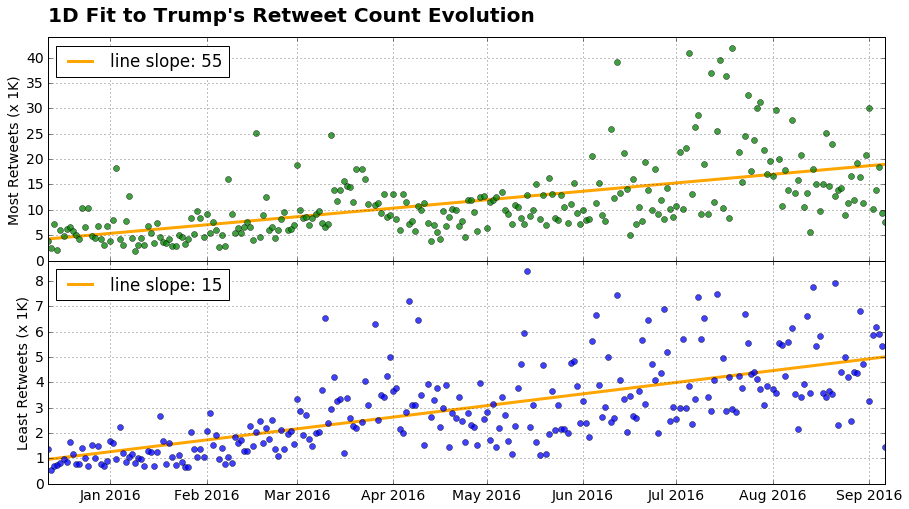

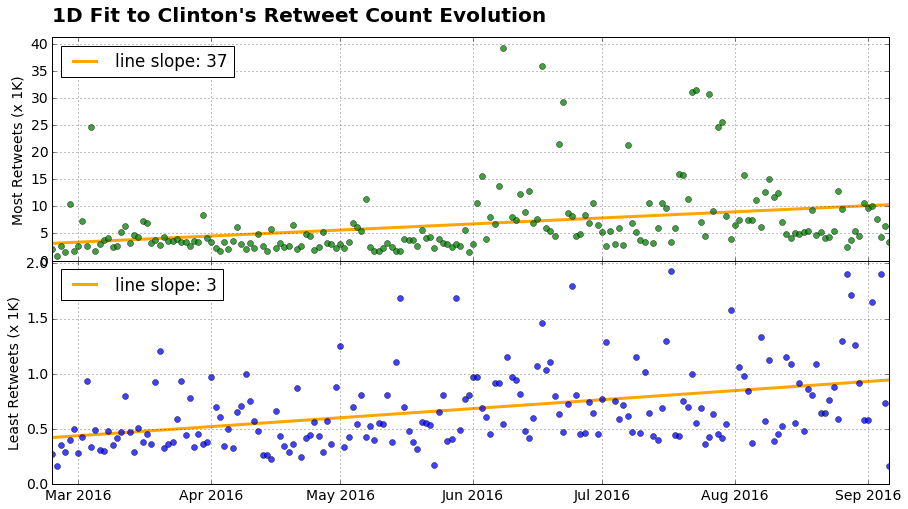

In [13]:
for candidate, df in zip(['Trump', 'Clinton'], [df_trump, df_clinton]):
    most_retweeted_tweets, least_retweeted_tweets = [], []

    for date, group in df.groupby(df['date']):
        if len(group) == 0:
            continue
        if group.retweet_count.sum() == 0:
            continue

        ix_max = group.retweet_count.argmax()
        most_retweeted_tweet_on_day = group.text.at[ix_max]
        retweets_received = group.retweet_count.at[ix_max]
        most_retweeted_tweets.append((date, retweets_received, most_retweeted_tweet_on_day))

        ix_min = group[group.retweet_count > 0].retweet_count.argmin()
        least_retweeted_tweet_on_day = group[group.retweet_count > 0].text.at[ix_min]
        least_retweets_received = group[group.retweet_count > 0].retweet_count.at[ix_min]
        least_retweeted_tweets.append((date, least_retweets_received, least_retweeted_tweet_on_day))

    # plot most retweets trend
    mean_retweets = np.mean([x[1] for x in most_retweeted_tweets])
    sig_retweets = np.std([x[1] for x in most_retweeted_tweets])
    x = mdates.date2num([x[0] for x in most_retweeted_tweets 
                         if mean_retweets - 3*sig_retweets < x[1] < mean_retweets + 3*sig_retweets])
    y = np.array([x[1] for x in most_retweeted_tweets 
                  if mean_retweets - 3*sig_retweets < x[1] < mean_retweets + 3*sig_retweets])

    coef = np.polyfit(x, y, 1)
    poly = np.poly1d(coef)

    fig, cx = plt.subplots(2, figsize=(15, 8), sharex=True)

    xx = np.linspace(x.min(), x.max(), 100)
    dd = mdates.num2date(xx)

    cx[0].plot(dd, poly(xx)/1e3, color='orange', 
               linestyle='solid', linewidth=3, label="line slope: %.0f" % coef[0])
    cx[0].plot(x, y/1e3, 'o', color='green', alpha=0.75)
    cx[0].set_ylabel('Most Retweets (x 1K)')
    cx[0].legend(loc='upper left')
    cx[0].set_ylim([0,np.max(y/1e3)*1.05])
    cx[0].grid()

    # plot least retweets trend
    mean_retweets = np.mean([x[1] for x in least_retweeted_tweets])
    sig_retweets = np.std([x[1] for x in least_retweeted_tweets])
    x = mdates.date2num([x[0] for x in least_retweeted_tweets 
                         if mean_retweets - 3*sig_retweets < x[1] < mean_retweets + 3*sig_retweets])
    y = np.array([x[1] for x in least_retweeted_tweets 
                  if mean_retweets - 3*sig_retweets < x[1] < mean_retweets + 3*sig_retweets])

    coef = np.polyfit(x, y, 1)
    poly = np.poly1d(coef)

    xx = np.linspace(x.min(), x.max(), 100)
    dd = mdates.num2date(xx)

    cx[1].plot(dd, poly(xx)/1e3, color='orange', 
               linestyle='solid', linewidth=3, label="line slope: %.0f" % coef[0])
    cx[1].plot(x, y/1e3, 'o', color='blue', alpha=0.75)
    cx[1].set_ylabel('Least Retweets (x 1K)')
    cx[1].legend(loc='upper left')
    cx[1].set_ylim([0,np.max(y/1e3)*1.05])
    cx[1].grid()

    cx[0].set_title("1D Fit to " + candidate + "'s Retweet Count Evolution", 
                    loc='left', y=1.05, fontsize='x-large', weight='heavy')

    fig.subplots_adjust(hspace=0)
    fig.savefig(root_dir + 'figs/1Dfit_" + candidate.lower() + "_retweeted_tweets_evolution.pdf')